In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from bgspy.nb_utils import load_learnedfuncs_in_dir
from bgspy.learn_utils import fit_dnn
from bgspy.learn import LearnedFunction
from bgspy.plots import loss_limits_plot

In [3]:
FIT_DIR = '../data/slim_sims/bmap_hg38/fits/'

res = load_learnedfuncs_in_dir(FIT_DIR)
res.keys()

2022-05-20 18:35:48.441093: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-20 18:35:51.104782: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 485 MB memory:  -> device: 0, name: GeForce RTX 2070, pci bus id: 0000:3b:00.0, compute capability: 7.5
2022-05-20 18:35:51.107081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 6120 MB memory:  -> device: 1, name: GeForce RTX 2070, pci bus id: 0000:5e:00.0, compute capability: 7.5
2022-05-20 18:35:51.108951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:

dict_keys([(0, 0, 0, 0, 4), (0, 0, 4, 2, 0), (0, 0, 0, 0, 2)])

In [4]:
y, X = res[(0, 0, 0, 0, 2)][0].func.y, res[(0, 0, 0, 0, 2)][0].func.X

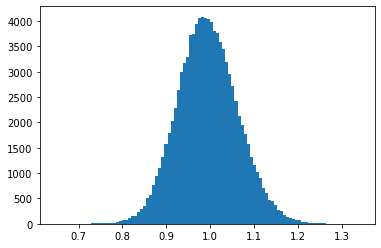

In [5]:
_ = plt.hist(y, 100)

In [6]:
class DownsampleTarget:
    def __init__(self, y, bins=100, rng=None):
        self.y = y.squeeze()
        self.bins = bins
        self.hist, self.bin_edges = np.histogram(y, bins=bins)
        self.seed = rng if isinstance(rng, int) else None
        self.rng = np.random.default_rng(self.seed) if rng is None else rng

    def downsample(self, level, truncate=True, replace=False):
        bin_item_idx = np.digitize(self.y, self.bin_edges)
        bin_items = defaultdict(list)
        
        for i, idx in enumerate(bin_item_idx.tolist()):
            bin_items[idx].append(i)
        sample = []
        for vals in bin_items.values():
            if len(vals) <= level:
                if not truncate:
                    sample.extend(vals)
            else:
                sample.extend(self.rng.choice(vals, size=level, replace=replace).tolist())
        return np.array(sample)

    def plot(self):
        return plt.bar(self.bin_edges[:-1], self.hist, width=np.diff(self.bin_edges)[0])
    

In [60]:
m = DownsampleTarget(y)
#plt.hist(m.downsample(level=100), bins=m.bin_edges)
idx = m.downsample(level=500)

In [61]:
domain = {'mu': (-10, -7, True),
         'sh': (-5, -1, True),
         'L': (1, 10000, False),
         'rbp': (-12, -7, True),
         'rf': (-10, -0.824, True)}

In [62]:
n = X.shape[0]
random_downsample = np.random.choice(np.arange(n), len(idx), replace=False)
func_rand = LearnedFunction(X[random_downsample, :], y[random_downsample, :], domain=domain)
func_rand.split()
func_rand.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=3,900)
Total size: 19,500

(array([3.000e+00, 5.800e+01, 5.650e+02, 3.116e+03, 6.574e+03, 5.965e+03,
        2.564e+03, 5.770e+02, 7.000e+01, 8.000e+00]),
 array([0.68519354, 0.74772041, 0.81024729, 0.87277416, 0.93530103,
        0.99782791, 1.06035478, 1.12288165, 1.18540852, 1.2479354 ,
        1.31046227]),
 <BarContainer object of 10 artists>)

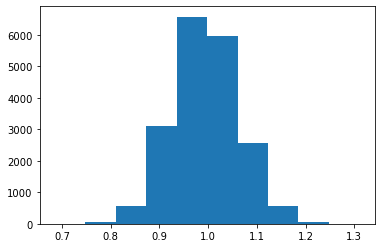

In [63]:
plt.hist(func_rand.y)

In [64]:
func = LearnedFunction(X[idx, :], y[idx, ], domain=domain)
func.split()
func.scale_features()

LearnedFunction with 5 feature(s)
 variable feature(s):
  - mu ∈ [-10, -7] (log10, <ufunc 'log10'>)
  - sh ∈ [-5, -1] (log10, <ufunc 'log10'>)
  - L ∈ [1, 10000] (linear, None)
  - rbp ∈ [-12, -7] (log10, <ufunc 'log10'>)
  - rf ∈ [-10, -0.824] (log10, <ufunc 'log10'>)
 fixed fixed(s) (based on metadata):
Features normalized? True
Features split? True, test size: 20.0% (n=3,900)
Total size: 19,500

(array([1944., 1967., 1957., 1936., 1962., 1925., 1971., 1938., 1953.,
        1947.]),
 array([0.86119053, 0.88822357, 0.9152566 , 0.94228964, 0.96932267,
        0.99635571, 1.02338874, 1.05042177, 1.07745481, 1.10448784,
        1.13152088]),
 <BarContainer object of 10 artists>)

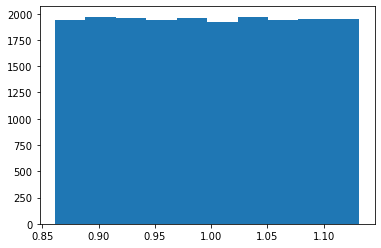

In [65]:
plt.hist(func.y)

In [ ]:
%%time
model, hist = fit_dnn(func, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='relu')

In [ ]:
%%time
model_rand, hist_rand = fit_dnn(func_rand, n128=0, n64=0, n32=0, n8=0, nx=2, output_activation='linear')

In [ ]:
history = hist.history
history_rand = hist_rand.history

plt.plot(history['loss'][1:], c='b')
plt.plot(history['val_loss'][1:], linestyle='dashed', c='b', label='uniformly downsampled target')

plt.plot(history_rand['loss'][1:], c='g')
plt.plot(history_rand['val_loss'][1:], linestyle='dashed', c='g', label='randomly downsampled target')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim(0, 0.03)

In [ ]:
func.model = model
func_rand.model = model_rand

In [ ]:
plt.scatter(func.y_test, func.predict_test())

In [ ]:
plt.scatter(func_rand.y_test, func_rand.predict_test())

In [ ]:
len(idx)